In [1]:
import os
import sys

In [2]:
os.chdir('/Users/frederictheunissen/Code/zebra-finch-memory-lesions/')

In [3]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels
import statsmodels.api as sm
import statsmodels.regression
import statsmodels.formula.api as smf
from matplotlib.gridspec import GridSpec
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from zf_data import Tsvk, load_trials
from zf_data.load_data import load_lesion_summary_table, load_ALL_lesion_summary_table
from zf_data.plotting import (
    border,
    color_by_reward,
    draw_k_axis,
    draw_logor_axes_markers,
    draw_probability_axes_markers,
    plot_pecking_test_data,
    figure_cm,
    fig_grid,
    smoothhist,
    shaded_line,
)
from zf_data.stats import false_discovery, likelihood_ratio_test, two_to_one_tail
from zf_data.utils import parse_p, setup_mpl_params
from zf_data.constants import *

/Users/frederictheunissen/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def get_or_create_Tsvk(df: pd.DataFrame, k_max: int = None) -> Tsvk:
    """Create a Tsvk instance from a dataframe, or return a cached one for that data
    
    If the df.index and k_max match a previously computed Tsvk, return that one. Otherwise,
    instantiate a new Tsvk() instance.
    
    Tsvk instances are hashed by a tuple of the dataframe index and k_max requested.
    """
    key = (tuple(df.index), k_max)
    if key not in get_or_create_Tsvk.cache:
        get_or_create_Tsvk.cache[key] = Tsvk(df, k_max=k_max)
    return get_or_create_Tsvk.cache[key]
get_or_create_Tsvk.cache = {}

def test_get_or_create_Tsvk(df: pd.DataFrame):
    backup = get_or_create_Tsvk.cache.copy()
    get_or_create_Tsvk.cache = {}
    t1 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t2 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t3 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=12)
    t4 = get_or_create_Tsvk(df[(df.LesionStage == "postlesion") & (df.VocalizerSet == "S2")], k_max=12)
    
    assert t1 is t2
    assert t1 is not t3
    assert t2 is not t3
    assert t1 is not t4
    assert t2 is not t4
    print("Tests pass")
    
    get_or_create_Tsvk.cache = backup

In [5]:
df = load_trials()

In [6]:
test_get_or_create_Tsvk(df)

Tests pass


In [7]:
setup_mpl_params()
SAVE_FIGS = False  #@param {type: "boolean"}
FIGDIR = "figures/svg_originals"  #@param {type: "string"}
FIGDIR = Path(FIGDIR)

# Create the folder for figure outputs
FIGDIR.mkdir(parents=True, exist_ok=True)

def savedir(rel_path):
    """Return the save path relative to FIGDIR"""
    return str(FIGDIR / rel_path)

# JNeurosci column sizes in cm, see https://www.jneurosci.org/content/information-authors
COL1 = 8.5  #@param {type: "number"}
COL1_5 = 11.6  #@param {type: "number"}
COL2 = 17.6  #@param {type: "number"}

In [8]:
NCM_lesion_summary_table = load_lesion_summary_table()
TOTAL_lesion_summary_table = load_ALL_lesion_summary_table()

In [11]:
NCM_lesion_summary_table

,Subject,L-CD (mm^3),L-CV (mm^3),L-RD (mm^3),L-RV (mm^3),R-CD (mm^3),R-CV (mm^3),R-RD (mm^3),R-RV (mm^3),TotalVolume (mm^3),HP,L,NCL,Cb,CM,HVC
0,BlaGre1349M,0.099476,0.000000,0.111854,0.000000,0.405746,0.031751,0.000000,0.000000,0.648828,1,0,1,0,0,0
1,XXXBlu0031M,0.134680,0.043486,0.182173,0.052694,0.000000,0.000000,0.099761,0.106353,0.619148,0,1,1,0,1,0
2,HpiGre0651M,0.096018,0.120710,0.140431,0.027856,0.139041,0.121493,0.206499,0.066585,0.918634,0,0,1,0,1,1
3,GreBla3404M,0.377925,0.132724,0.008446,0.000000,0.015056,0.058582,0.000000,0.000000,0.592733,1,0,0,0,0,0
4,GreBlu5039F,0.115266,0.025727,0.192688,0.000000,0.051460,0.008768,0.000000,0.000000,0.393909,2,1,0,1,1,0
5,WhiBlu5805F,0.091170,0.025224,0.202312,0.005355,0.013773,0.000000,0.296019,0.000000,0.633853,0,2,3,0,1,0
6,RedHpi0710F,0.028780,0.046094,0.101825,0.004671,0.009868,0.027441,0.092718,0.078331,0.389727,1,0,2,0,1,1
7,XXXOra0037F,0.035109,0.325156,0.000000,0.000000,0.056495,0.126573,0.017544,0.131676,0.692553,0,0,2,0,0,0
8,XXXHpi0038M,0.089552,0.003205,0.062383,0.000000,0.075883,0.000000,0.000000,0.000000,0.231024,2,0,0,1,0,0
9,GraWhi4040F,0.012917,0.013011,0.000000,0.000000,0.165030,0.127069,0.003658,0.000000,0.321686,0,0,0,0,0,0


In [12]:
TOTAL_lesion_summary_table

,Subject,NCM-L(mm^3),NCM-R(mm^3),HP (mm^3),L (mm^3),NCL (mm^3),Cb (mm^3),CM (mm^3),HVC (mm^3),TotalVolume (mm^3),HP,L,NCL,Cb,CM,HVC
0,BlaGre1349M,0.208257,0.441539,0.159625,0.000000,0.027428,0.000000,0.000000,0.000000,0.836849,1,0,1,0,0,0
1,XXXBlu0031M,0.394386,0.210968,0.000000,0.011003,0.113669,0.000000,0.004131,0.000000,0.734157,0,1,1,0,1,0
2,HpiGre0651M,0.416895,0.599421,0.000000,0.006691,0.863437,0.000000,0.067292,0.107402,2.061138,0,0,1,0,1,1
3,GreBla3404M,0.521660,0.073638,0.034012,0.000000,0.000000,0.035782,0.000000,0.000000,0.665092,1,0,0,0,0,0
4,GreBlu5039F,0.319405,0.060228,0.394583,0.009789,0.000000,0.101597,0.022477,0.000000,0.908078,2,1,0,1,1,0
5,WhiBlu5805F,0.398386,0.404802,0.000000,0.359296,0.506234,0.000000,0.133045,0.000000,1.801763,0,2,3,0,1,0
6,RedHpi0710F,0.228880,0.296219,0.107732,0.006335,0.433091,0.000000,0.025359,0.072072,1.169688,1,0,2,0,1,1
7,XXXOra0037F,0.370265,0.272159,0.088290,0.000000,0.149752,0.058682,0.000000,0.000000,0.939148,0,0,2,0,0,0
8,XXXHpi0038M,0.161117,0.139971,0.310445,0.000000,0.000000,1.038904,0.000000,0.000000,1.650436,2,0,0,1,0,0
9,GraWhi4040F,0.025929,0.302277,0.000000,0.000000,0.057182,0.000000,0.000000,0.000000,0.385387,0,0,0,0,0,0


In [9]:
def get_NCM_lesion_size(subject):
    if np.any(NCM_lesion_summary_table.Subject == subject):
        return NCM_lesion_summary_table[NCM_lesion_summary_table.Subject == subject].iloc[0]["TotalVolume (mm^3)"]
    else:
        return 0.0

In [10]:
def get_NCM_lesion_by_hemi(subject):
    if np.any(TOTAL_lesion_summary_table.Subject == subject):
        left = TOTAL_lesion_summary_table[TOTAL_lesion_summary_table.Subject == subject].iloc[0]["NCM-L(mm^3)"]
        right = TOTAL_lesion_summary_table[TOTAL_lesion_summary_table.Subject == subject].iloc[0]["NCM-R(mm^3)"]
        # currently returning the LOWER value on the assumption that other (more intact) side can compensate
        if left > right:
            return right
        else:
            return left
    else:
        return 0.0

In [11]:
def get_total_lesion_size(subject):
    if np.any(TOTAL_lesion_summary_table.Subject == subject):
        return TOTAL_lesion_summary_table[TOTAL_lesion_summary_table.Subject == subject].iloc[0]["TotalVolume (mm^3)"]
    else:
        return 0.0

In [12]:
# this is the original Fig 7 from the paper

def figure_7(call_type: str, ax: plt.Axes = None):
    """Create a scatter plot between NCM lesion size and change in logOR before and after lesion
    
    Also fit a best fit line just to the NCM points
    """
    if ax is None:
        ax = plt.gca()
        
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_S1_pre = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        tsvk_S1_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        
        scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
        scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
        assert np.all(scores_1["Subject"] == scores_2["Subject"])
        delta = scores_2["logOR"] - scores_1["logOR"]
        
        lesion_sizes = [get_NCM_lesion_size(subject) for subject in scores_1["Subject"]]
        
        ax.scatter(
            lesion_sizes,
            delta,
            s=30,
            linewidth=1,
            facecolor="none",
            label=treatment,
            edgecolor=COLORMAP[treatment]
        )
        
        if treatment == "NCM":
            x_data = lesion_sizes
            y_data = delta

            x_data = sm.add_constant(x_data)
            result = statsmodels.regression.linear_model.OLS(y_data, x_data)
            r = np.corrcoef(x_data[:, 1], y_data)[0, 1]
            result = result.fit()
            print(f"Best fit line to NCM data ({call_type})")
            print("-------------------------")
            
            print(f" r = {r:.2f}, F({result.df_model:.0f}, {result.df_resid:.0f}) = {result.fvalue:.2f} {parse_p(result.f_pvalue)}, R2_adj = {result.rsquared_adj:.2f}")
            print()
            
            x = np.linspace(-0.1, 1.1, num=3)
            ax.plot(x, result.params[0] + result.params[1] * x, linewidth=1, color=NCM_COLOR, linestyle="--", zorder=-1)

            pvalue = result.pvalues[1]
            r2_adj = result.rsquared_adj
            ax.text(
                0.04,
                0.02, 
                "$R^2_{adj}$" + f"={r2_adj:.2f}\n" + "$p=$" + f"{pvalue:.2f}",
                fontsize=8, 
                verticalalignment="bottom",
                horizontalalignment="left",
                color=NCM_COLOR,
                transform=ax.transAxes
            )

Figure Dimensions 10.60cm x 5.00cm

Best fit line to NCM data (SO)
-------------------------
 r = -0.28, F(1, 8) = 0.70 p = 0.426, R2_adj = -0.03

Best fit line to NCM data (DC)
-------------------------
 r = -0.50, F(1, 8) = 2.72 p = 0.138, R2_adj = 0.16



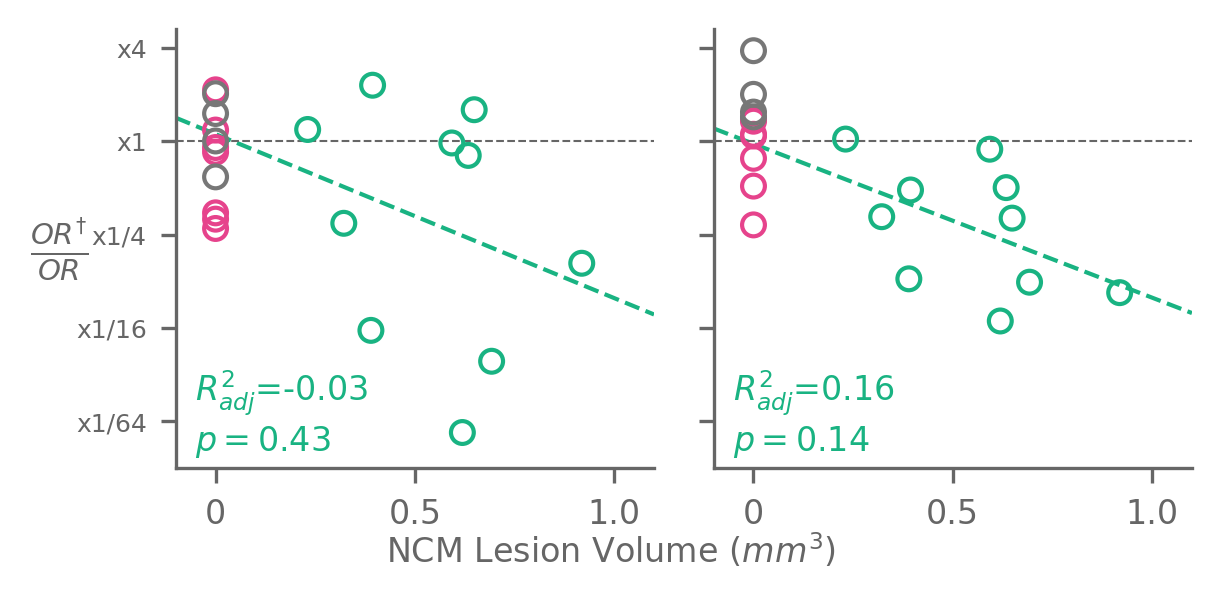

In [17]:
fig = figure_cm(COL1_5 - 1, 5, dpi=300)

print()
axes = fig.subplots(1, 2, sharey=True)#  gridspec_kw={"hspace": 1.0})
figure_7("SO", ax=axes[0])
figure_7("DC", ax=axes[1])

axes[0].set_ylabel(r"$\frac{OR^{\dagger}}{OR}$", fontsize=10, verticalalignment="center", rotation=0)

for ax in axes:
    ax.set_xlim(-0.1, 1.1)
    border(ax, 1, 0, 0, 1)
    draw_logor_axes_markers(smallest=-7, biggest=2, convert_log=False, ax=ax)
    ax.set_ylim(-7, 2.4)
    ax.set_xticks([0, 0.5, 1.0], [0, 0.5, 1.0], fontsize=8)

fig.tight_layout()
fig.supxlabel("NCM Lesion Volume ($mm^3$)", fontsize=8)

if SAVE_FIGS:
    fig.savefig(savedir("fig7.svg"), format="svg", bbox_inches="tight")


In [18]:
# this function calls get_NCM_lesion_by_hemi() to show the correlation between OR performance and 
# size of the lesion on the less-damaged hemisphere.  the hypothesis is that the less-damaged hemisphere could 
# compensate for the damage on the other side

def figure_7_hemi(call_type: str, ax: plt.Axes = None):
    """Create a scatter plot between NCM lesion size and change in logOR before and after lesion
    
    Also fit a best fit line just to the NCM points
    """
    if ax is None:
        ax = plt.gca()
        
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_S1_pre = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        tsvk_S1_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        
        scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
        scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
        assert np.all(scores_1["Subject"] == scores_2["Subject"])
        delta = scores_2["logOR"] - scores_1["logOR"]
        
        lesion_sizes = [get_NCM_lesion_by_hemi(subject) for subject in scores_1["Subject"]]
        
        ax.scatter(
            lesion_sizes,
            delta,
            s=30,
            linewidth=1,
            facecolor="none",
            label=treatment,
            edgecolor=COLORMAP[treatment]
        )
        
        if treatment == "NCM":
            x_data = lesion_sizes
            y_data = delta

            x_data = sm.add_constant(x_data)
            result = statsmodels.regression.linear_model.OLS(y_data, x_data)
            r = np.corrcoef(x_data[:, 1], y_data)[0, 1]
            result = result.fit()
            print(f"Best fit line to NCM data ({call_type})")
            print("-------------------------")
            
            print(f" r = {r:.2f}, F({result.df_model:.0f}, {result.df_resid:.0f}) = {result.fvalue:.2f} {parse_p(result.f_pvalue)}, R2_adj = {result.rsquared_adj:.2f}")
            print()
            
            x = np.linspace(-0.1, 0.6, num=3)
            ax.plot(x, result.params[0] + result.params[1] * x, linewidth=1, color=NCM_COLOR, linestyle="--", zorder=-1)

            pvalue = result.pvalues[1]
            r2_adj = result.rsquared_adj
            ax.text(
                0.04,
                0.02, 
                "$R^2_{adj}$" + f"={r2_adj:.2f}\n" + "$p=$" + f"{pvalue:.2f}",
                fontsize=8, 
                verticalalignment="bottom",
                horizontalalignment="left",
                color=NCM_COLOR,
                transform=ax.transAxes
            )

Figure Dimensions 10.60cm x 5.00cm

Best fit line to NCM data (SO)
-------------------------
 r = -0.31, F(1, 8) = 0.86 p = 0.382, R2_adj = -0.02

Best fit line to NCM data (DC)
-------------------------
 r = -0.46, F(1, 8) = 2.13 p = 0.182, R2_adj = 0.11



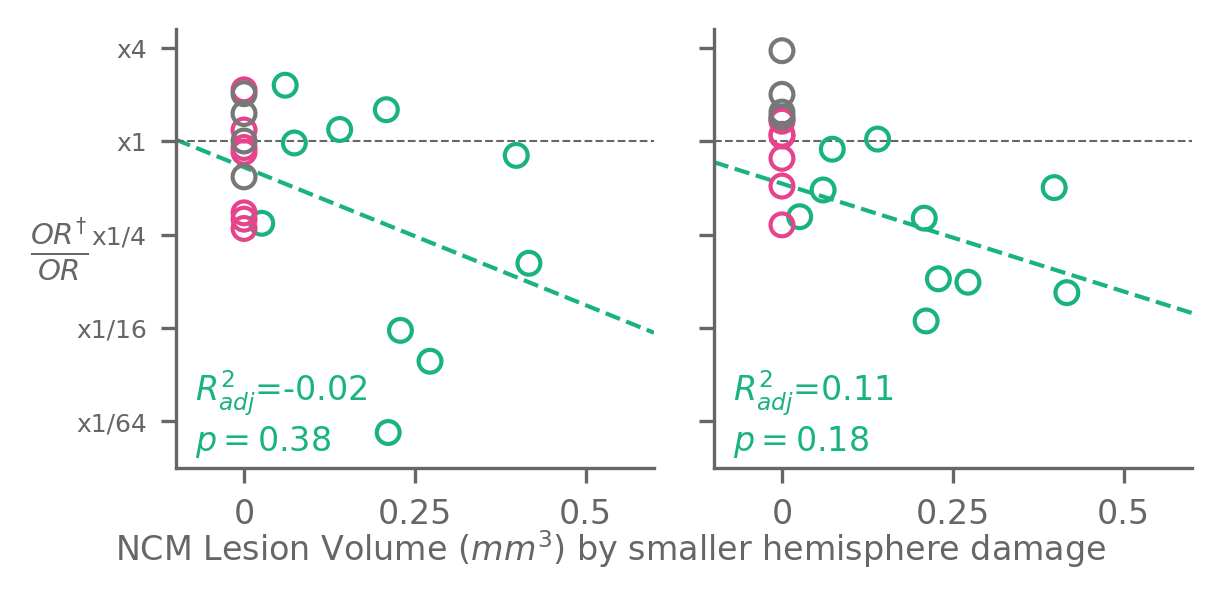

In [19]:
fig = figure_cm(COL1_5 - 1, 5, dpi=300)

print()
axes = fig.subplots(1, 2, sharey=True)#  gridspec_kw={"hspace": 1.0})
figure_7_hemi("SO", ax=axes[0])
figure_7_hemi("DC", ax=axes[1])

axes[0].set_ylabel(r"$\frac{OR^{\dagger}}{OR}$", fontsize=10, verticalalignment="center", rotation=0)

for ax in axes:
    ax.set_xlim(-0.1, 0.6)
    border(ax, 1, 0, 0, 1)
    draw_logor_axes_markers(smallest=-7, biggest=2, convert_log=False, ax=ax)
    ax.set_ylim(-7, 2.4)
    ax.set_xticks([0, 0.25, 0.5], [0, 0.25, 0.5], fontsize=8)

fig.tight_layout()
fig.supxlabel("NCM Lesion Volume ($mm^3$) by smaller hemisphere damage", fontsize=8)

if SAVE_FIGS:
    fig.savefig(savedir("fig7.svg"), format="svg", bbox_inches="tight")


In [41]:
# this function can be modified to look at any particular quadrant.
# the RostralVentral quadrant has the greatest effect on performance

def get_NCM_lesion_by_quad(subject):
    if np.any(NCM_lesion_summary_table.Subject == subject):
        leftRV = NCM_lesion_summary_table[NCM_lesion_summary_table.Subject == subject].iloc[0]["L-RV (mm^3)"]
        rightRV = NCM_lesion_summary_table[NCM_lesion_summary_table.Subject == subject].iloc[0]["R-RV (mm^3)"]
        #leftCV = NCM_lesion_summary_table[NCM_lesion_summary_table.Subject == subject].iloc[0]["L-CV (mm^3)"]
        #rightCV = NCM_lesion_summary_table[NCM_lesion_summary_table.Subject == subject].iloc[0]["R-CV (mm^3)"]
        return leftRV + rightRV # + leftCV + rightCV
    else:
        return 0.0

In [147]:
def figure_7_quad(call_type: str, ax: plt.Axes = None):
    """Create a scatter plot between NCM lesion size and change in logOR before and after lesion
    
    Also fit a best fit line just to the NCM points
    """
    if ax is None:
        ax = plt.gca()
        
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_S1_pre = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        tsvk_S1_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        
        scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
        scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
        assert np.all(scores_1["Subject"] == scores_2["Subject"])
        delta = scores_2["logOR"] - scores_1["logOR"]
        
        lesion_sizes = [get_NCM_lesion_by_quad(subject) for subject in scores_1["Subject"]]
        
        ax.scatter(
            lesion_sizes,
            delta,
            s=30,
            linewidth=1,
            facecolor="none",
            label=treatment,
            edgecolor=COLORMAP[treatment]
        )
        
        if treatment == "NCM":
            x_data = lesion_sizes
            y_data = delta

            x_data = sm.add_constant(x_data)
            result = statsmodels.regression.linear_model.OLS(y_data, x_data)
            r = np.corrcoef(x_data[:, 1], y_data)[0, 1]
            result = result.fit()
            print(f"Best fit line to NCM data ({call_type})")
            print("-------------------------")
            
            print(f" r = {r:.2f}, F({result.df_model:.0f}, {result.df_resid:.0f}) = {result.fvalue:.2f} {parse_p(result.f_pvalue)}, R2_adj = {result.rsquared_adj:.2f}")
            print()
            
            x = np.linspace(-0.1, 0.6, num=3)
            ax.plot(x, result.params[0] + result.params[1] * x, linewidth=1, color=NCM_COLOR, linestyle="--", zorder=-1)

            pvalue = result.pvalues[1]
            r2_adj = result.rsquared_adj
            ax.text(
                0.04,
                0.02, 
                "$R^2_{adj}$" + f"={r2_adj:.2f}\n" + "$p=$" + f"{pvalue:.2f}",
                fontsize=8, 
                verticalalignment="bottom",
                horizontalalignment="left",
                color=NCM_COLOR,
                transform=ax.transAxes
            )

Figure Dimensions 10.60cm x 5.00cm

Best fit line to NCM data (SO)
-------------------------
 r = -0.94, F(1, 8) = 59.72 p < 0.001 (***), R2_adj = 0.87

Best fit line to NCM data (DC)
-------------------------
 r = -0.90, F(1, 8) = 33.43 p < 0.001 (***), R2_adj = 0.78



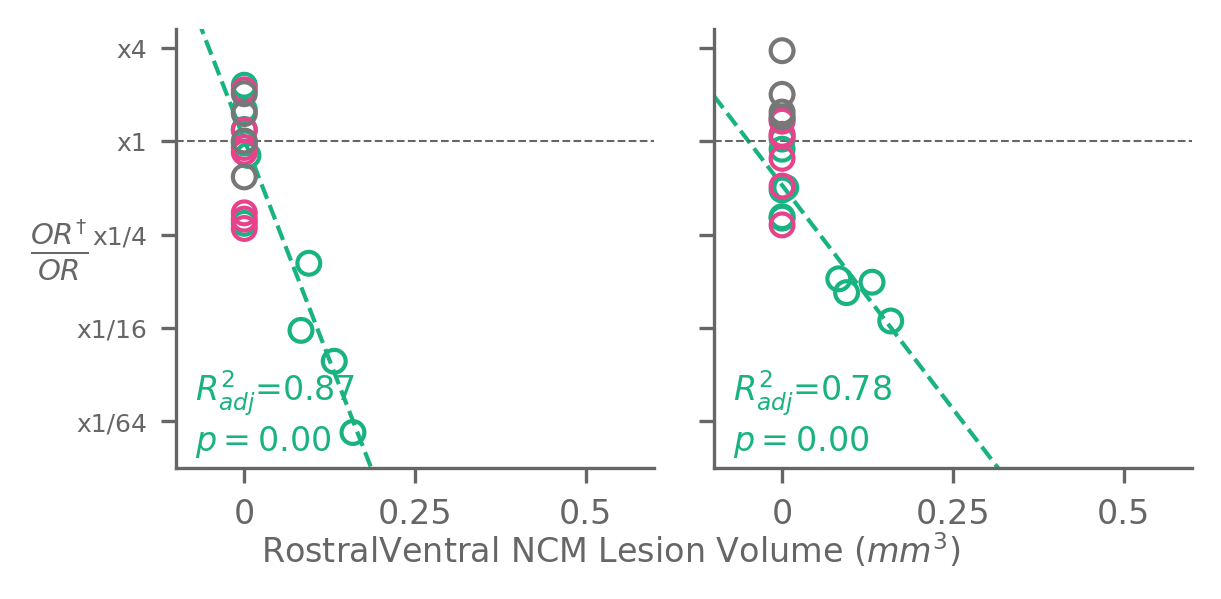

In [148]:
fig = figure_cm(COL1_5 - 1, 5, dpi=300)

print()
axes = fig.subplots(1, 2, sharey=True)#  gridspec_kw={"hspace": 1.0})
figure_7_quad("SO", ax=axes[0])
figure_7_quad("DC", ax=axes[1])

axes[0].set_ylabel(r"$\frac{OR^{\dagger}}{OR}$", fontsize=10, verticalalignment="center", rotation=0)

for ax in axes:
    ax.set_xlim(-0.1, 0.6)
    border(ax, 1, 0, 0, 1)
    draw_logor_axes_markers(smallest=-7, biggest=2, convert_log=False, ax=ax)
    ax.set_ylim(-7, 2.4)
    ax.set_xticks([0, 0.25, 0.5], [0, 0.25, 0.5], fontsize=8)

fig.tight_layout()
fig.supxlabel("RostralVentral NCM Lesion Volume ($mm^3$)", fontsize=8)

if SAVE_FIGS:
    fig.savefig(savedir("fig7.svg"), format="svg", bbox_inches="tight")


In [73]:
def figure_7_initial(call_type: list, anatomy: str, k_val=11, ax: plt.Axes = None):
    """Create a scatter plot between NCM lesion size and change in logOR before and after lesion
    
    Also fit a best fit line just to the NCM points
    """
    if ax is None:
        ax = plt.gca()
        
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_S1_pre = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & df.StimulusCallType.isin(call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])], k_max = k_val)

        tsvk_S1_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & df.StimulusCallType.isin(call_type)
            & (df.SubjectTreatment == treatment)
        ], k_max = k_val) 

        logORAll = tsvk_S1_pre.logOR_by_subjects(k=0)
        logORAll['k'] = 0
        for k in range(k_val):
            logOR = tsvk_S1_pre.logOR_by_subjects(k=k+1)
            logOR['k'] = k+1
            logORAll = pd.concat([logORAll, logOR], ignore_index = True)    
        scores_1 = logORAll.groupby('Subject').mean()

        logORAll = tsvk_S1_post.logOR_by_subjects(k=0)
        logORAll['k'] = 0
        for k in range(k_val):
            logOR = tsvk_S1_post.logOR_by_subjects(k=k+1)
            logOR['k'] = k+1
            logORAll = pd.concat([logORAll, logOR], ignore_index = True)   
        scores_2 = logORAll.groupby('Subject').mean()
        
        assert np.all(scores_1.index == scores_2.index)
        delta = scores_2["logOR"] - scores_1["logOR"]

        
        if anatomy == 'Total':
            lesion_sizes = [get_total_lesion_size(subject) for subject in scores_1.index]
        elif anatomy == 'vNCM':
            lesion_sizes = [get_NCM_lesion_by_quad(subject) for subject in scores_1.index]
        elif anatomy == 'NCM':
            lesion_sizes = [get_NCM_lesion_size(subject) for subject in scores_1.index]
        
        ax.scatter(
            lesion_sizes,
            delta,
            s=30,
            linewidth=1,
            facecolor="none",
            label=treatment,
            edgecolor=COLORMAP[treatment]
        )
        
        if treatment == "NCM":
            x_data = lesion_sizes
            y_data = delta

            x_data = sm.add_constant(x_data)
            result = statsmodels.regression.linear_model.OLS(y_data, x_data)
            r = np.corrcoef(x_data[:, 1], y_data)[0, 1]
            result = result.fit()
            print(f"Best fit line to NCM data (DC+Song)")
            print("-------------------------")
            
            print(f" r = {r:.2f}, F({result.df_model:.0f}, {result.df_resid:.0f}) = {result.fvalue:.2f} {parse_p(result.f_pvalue)}, R2_adj = {result.rsquared_adj:.2f}")
            print()
            
            x = np.linspace(-0.1, 2.1, num=3)
            ax.plot(x, result.params[0] + result.params[1] * x, linewidth=1, color=NCM_COLOR, linestyle="--", zorder=-1)

            pvalue = result.pvalues[1]
            r2_adj = result.rsquared_adj
            ax.text(
                0.04,
                0.02, 
                "$R^2_{adj}$" + f"={r2_adj:.2f}\n" + "$p=$" + f"{pvalue:.2f}",
                fontsize=8, 
                verticalalignment="bottom",
                horizontalalignment="left",
                color=NCM_COLOR,
                transform=ax.transAxes
            )
            ax.set_xlabel(anatomy+'Lesion Volume ($mm^3$)')

Figure Dimensions 16.60cm x 5.00cm
Log OR calculated for the first 3 Informative Trials. d2 prelesion, d1 postlesion
Best fit line to NCM data (DC+Song)
-------------------------
 r = 0.44, F(1, 8) = 1.93 p = 0.202, R2_adj = 0.09

Best fit line to NCM data (DC+Song)
-------------------------
 r = -0.00, F(1, 8) = 0.00 p = 0.996, R2_adj = -0.12

Best fit line to NCM data (DC+Song)
-------------------------
 r = -0.67, F(1, 8) = 6.63 p = 0.033 (*), R2_adj = 0.38



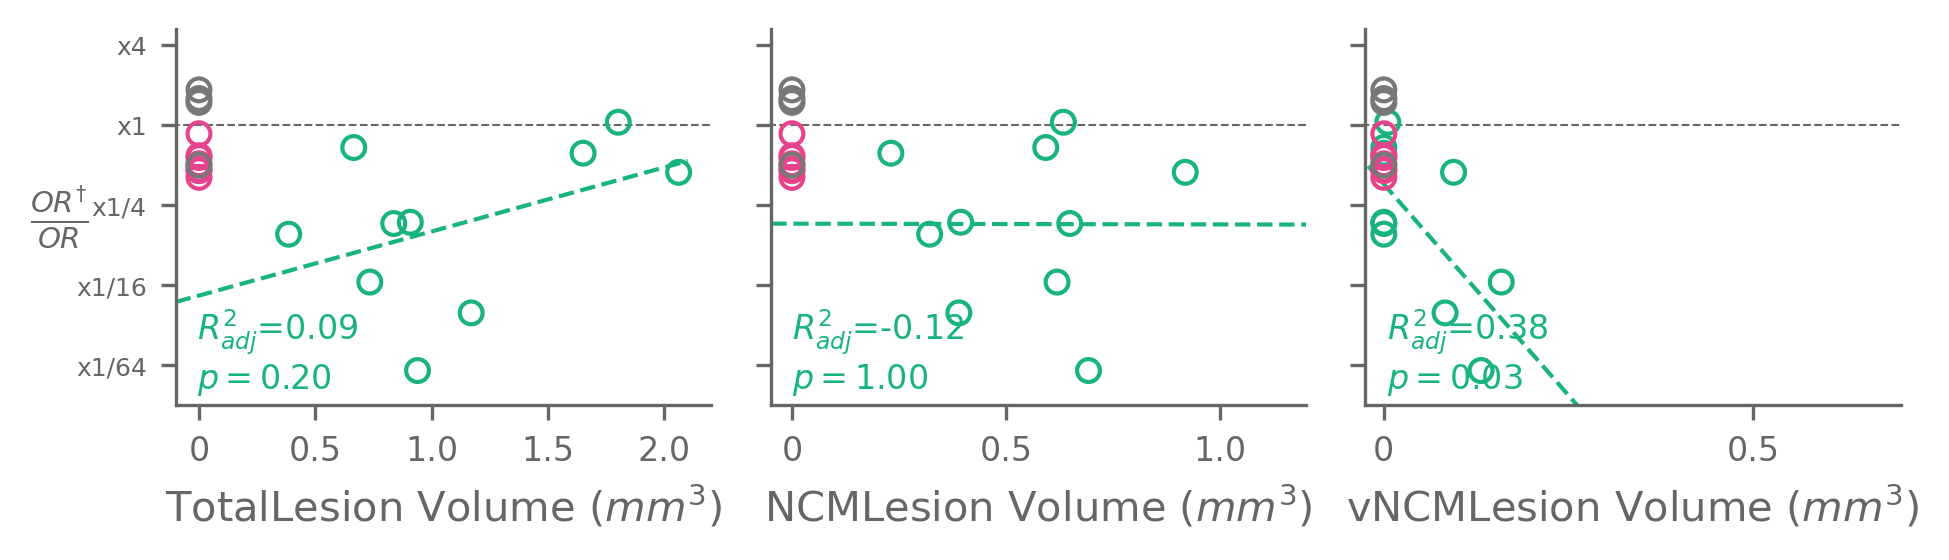

In [74]:
fig = figure_cm(COL2 - 1, 5, dpi=300)
k_max = 3
print('Log OR calculated for the first %d Informative Trials. d2 prelesion, d1 postlesion' % k_max)
axes = fig.subplots(1, 3, sharey=True)#  gridspec_kw={"hspace": 1.0})
figure_7_initial(call_type = ['SO', 'DC'], anatomy = 'Total', k_val = k_max, ax=axes[0])
figure_7_initial(call_type = ['SO', 'DC'], anatomy = 'NCM', k_val = k_max, ax=axes[1])
figure_7_initial(call_type = ['SO', 'DC'], anatomy = 'vNCM', k_val = k_max, ax=axes[2])

axes[0].set_ylabel(r"$\frac{OR^{\dagger}}{OR}$", fontsize=10, verticalalignment="center", rotation=0)

for ax in axes:
    border(ax, 1, 0, 0, 1)
    draw_logor_axes_markers(smallest=-7, biggest=2, convert_log=False, ax=ax)
    ax.set_ylim(-7, 2.4)
    
    #ax.set_xlim(-0.1, 2.2)
    #ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0], [0, 0.5, 1.0, 1.5, 2.0], fontsize=8)

# Different x axis
axes[0].set_xlim(-0.1, 2.2)
axes[0].set_xticks([0, 0.5, 1.0, 1.5, 2.0], [0, 0.5, 1.0, 1.5, 2.0], fontsize=8)
axes[1].set_xlim(-0.05, 1.2)
axes[1].set_xticks([0, 0.5, 1.0], [0, 0.5, 1.0], fontsize=8)
axes[2].set_xlim(-0.025, 0.7)
axes[2].set_xticks([0, 0.5], [0, 0.5], fontsize=8)

fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(savedir("fig7_new_early.svg"), format="svg", bbox_inches="tight")


In [75]:
# new TOTAL lesion values modification: same fig except total lesion size instead of NCM lesion size
def figure_7_new(call_type: list, anatomy: str, ax: plt.Axes = None):
    """Create a scatter plot between NCM lesion size and change in logOR before and after lesion
    
    Also fit a best fit line just to the NCM points
    """
    if ax is None:
        ax = plt.gca()
        
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_S1_pre = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & df.StimulusCallType.isin(call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        tsvk_S1_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & df.StimulusCallType.isin(call_type)
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
        ])
        
        scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
        scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
        assert np.all(scores_1["Subject"] == scores_2["Subject"])
        delta = scores_2["logOR"] - scores_1["logOR"]
        
        if anatomy == 'Total':
            lesion_sizes = [get_total_lesion_size(subject) for subject in scores_1["Subject"]]
        elif anatomy == 'vNCM':
            lesion_sizes = [get_NCM_lesion_by_quad(subject) for subject in scores_1["Subject"]]
        elif anatomy == 'NCM':
            lesion_sizes = [get_NCM_lesion_size(subject) for subject in scores_1["Subject"]]

        ax.scatter(
            lesion_sizes,
            delta,
            s=30,
            linewidth=1,
            facecolor="none",
            label=treatment,
            edgecolor=COLORMAP[treatment]
        )
        
        if treatment == "NCM":
            x_data = lesion_sizes
            y_data = delta

            x_data = sm.add_constant(x_data)
            result = statsmodels.regression.linear_model.OLS(y_data, x_data)
            r = np.corrcoef(x_data[:, 1], y_data)[0, 1]
            result = result.fit()
            print(f"Best fit line to total lesion size data ({call_type})")
            print("------------------------------------------------")
            
            print(f" r = {r:.2f}, F({result.df_model:.0f}, {result.df_resid:.0f}) = {result.fvalue:.2f} {parse_p(result.f_pvalue)}, R2_adj = {result.rsquared_adj:.2f}")
            print()
            
            x = np.linspace(-0.1, 2.1, num=5)
            ax.plot(x, result.params[0] + result.params[1] * x, linewidth=1, color=NCM_COLOR, linestyle="--", zorder=-1)

            pvalue = result.pvalues[1]
            r2_adj = result.rsquared_adj
            ax.text(
                0.04,
                0.02, 
                "$R^2_{adj}$" + f"={r2_adj:.2f}\n" + "$p=$" + f"{pvalue:.2f}",
                fontsize=8, 
                verticalalignment="bottom",
                horizontalalignment="left",
                color=NCM_COLOR,
                transform=ax.transAxes
            )
            ax.set_xlabel(anatomy+'Lesion Volume ($mm^3$)')

Figure Dimensions 16.60cm x 5.00cm

Best fit line to total lesion size data (['SO', 'DC'])
------------------------------------------------
 r = 0.11, F(1, 8) = 0.10 p = 0.764, R2_adj = -0.11

Best fit line to total lesion size data (['SO', 'DC'])
------------------------------------------------
 r = -0.42, F(1, 8) = 1.69 p = 0.230, R2_adj = 0.07

Best fit line to total lesion size data (['SO', 'DC'])
------------------------------------------------
 r = -0.89, F(1, 8) = 29.61 p = 0.001 (***), R2_adj = 0.76



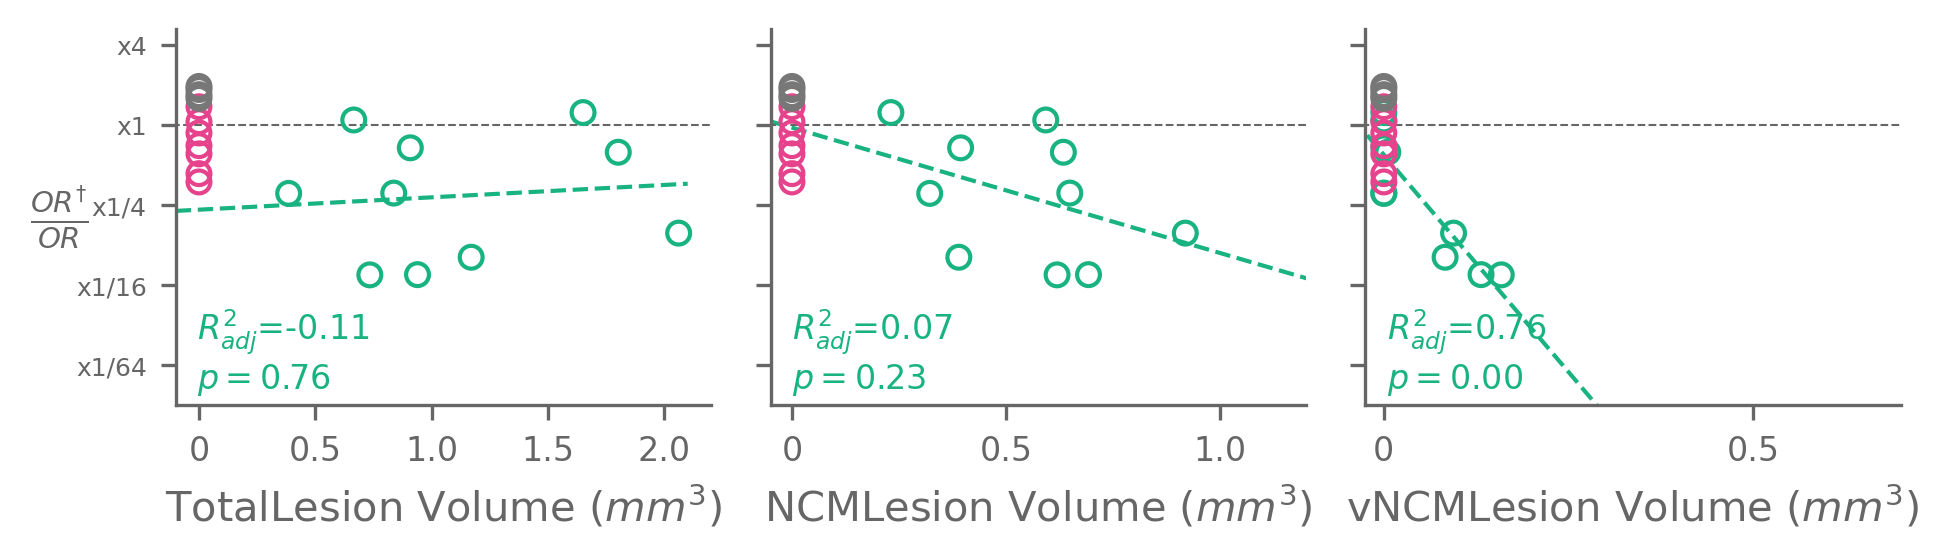

In [83]:
fig = figure_cm(COL2 - 1, 5, dpi=300)

print()
axes = fig.subplots(1, 3, sharey=True)#  gridspec_kw={"hspace": 1.0})
figure_7_new(call_type = ['SO', 'DC'], anatomy = 'Total', ax=axes[0])
figure_7_new(call_type = ['SO', 'DC'], anatomy = 'NCM', ax=axes[1])
figure_7_new(call_type = ['SO', 'DC'], anatomy = 'vNCM', ax=axes[2])

axes[0].set_ylabel(r"$\frac{OR^{\dagger}}{OR}$", fontsize=10, verticalalignment="center", rotation=0)

for ax in axes:
    border(ax, 1, 0, 0, 1)
    draw_logor_axes_markers(smallest=-7, biggest=2, convert_log=False, ax=ax)
    ax.set_ylim(-7, 2.4)
    
    #ax.set_xlim(-0.1, 2.2)
    #ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0], [0, 0.5, 1.0, 1.5, 2.0], fontsize=8)

# Different x axis
axes[0].set_xlim(-0.1, 2.2)
axes[0].set_xticks([0, 0.5, 1.0, 1.5, 2.0], [0, 0.5, 1.0, 1.5, 2.0], fontsize=8)
axes[1].set_xlim(-0.05, 1.2)
axes[1].set_xticks([0, 0.5, 1.0], [0, 0.5, 1.0], fontsize=8)
axes[2].set_xlim(-0.025, 0.7)
axes[2].set_xticks([0, 0.5], [0, 0.5], fontsize=8)

fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(savedir("fig7_new.svg"), format="svg", bbox_inches="tight")


In [84]:
fig.savefig(savedir("fig7_new.svg"), format="svg", bbox_inches="tight")

Figure Dimensions 16.60cm x 10.00cm

Best fit line to total lesion size data (['SO'])
------------------------------------------------
 r = 0.10, F(1, 8) = 0.09 p = 0.775, R2_adj = -0.11

Best fit line to total lesion size data (['SO'])
------------------------------------------------
 r = -0.28, F(1, 8) = 0.70 p = 0.426, R2_adj = -0.03

Best fit line to total lesion size data (['SO'])
------------------------------------------------
 r = -0.94, F(1, 8) = 59.72 p < 0.001 (***), R2_adj = 0.87

Best fit line to total lesion size data (['DC'])
------------------------------------------------
 r = 0.01, F(1, 8) = 0.00 p = 0.986, R2_adj = -0.12

Best fit line to total lesion size data (['DC'])
------------------------------------------------
 r = -0.50, F(1, 8) = 2.72 p = 0.138, R2_adj = 0.16

Best fit line to total lesion size data (['DC'])
------------------------------------------------
 r = -0.90, F(1, 8) = 33.43 p < 0.001 (***), R2_adj = 0.78



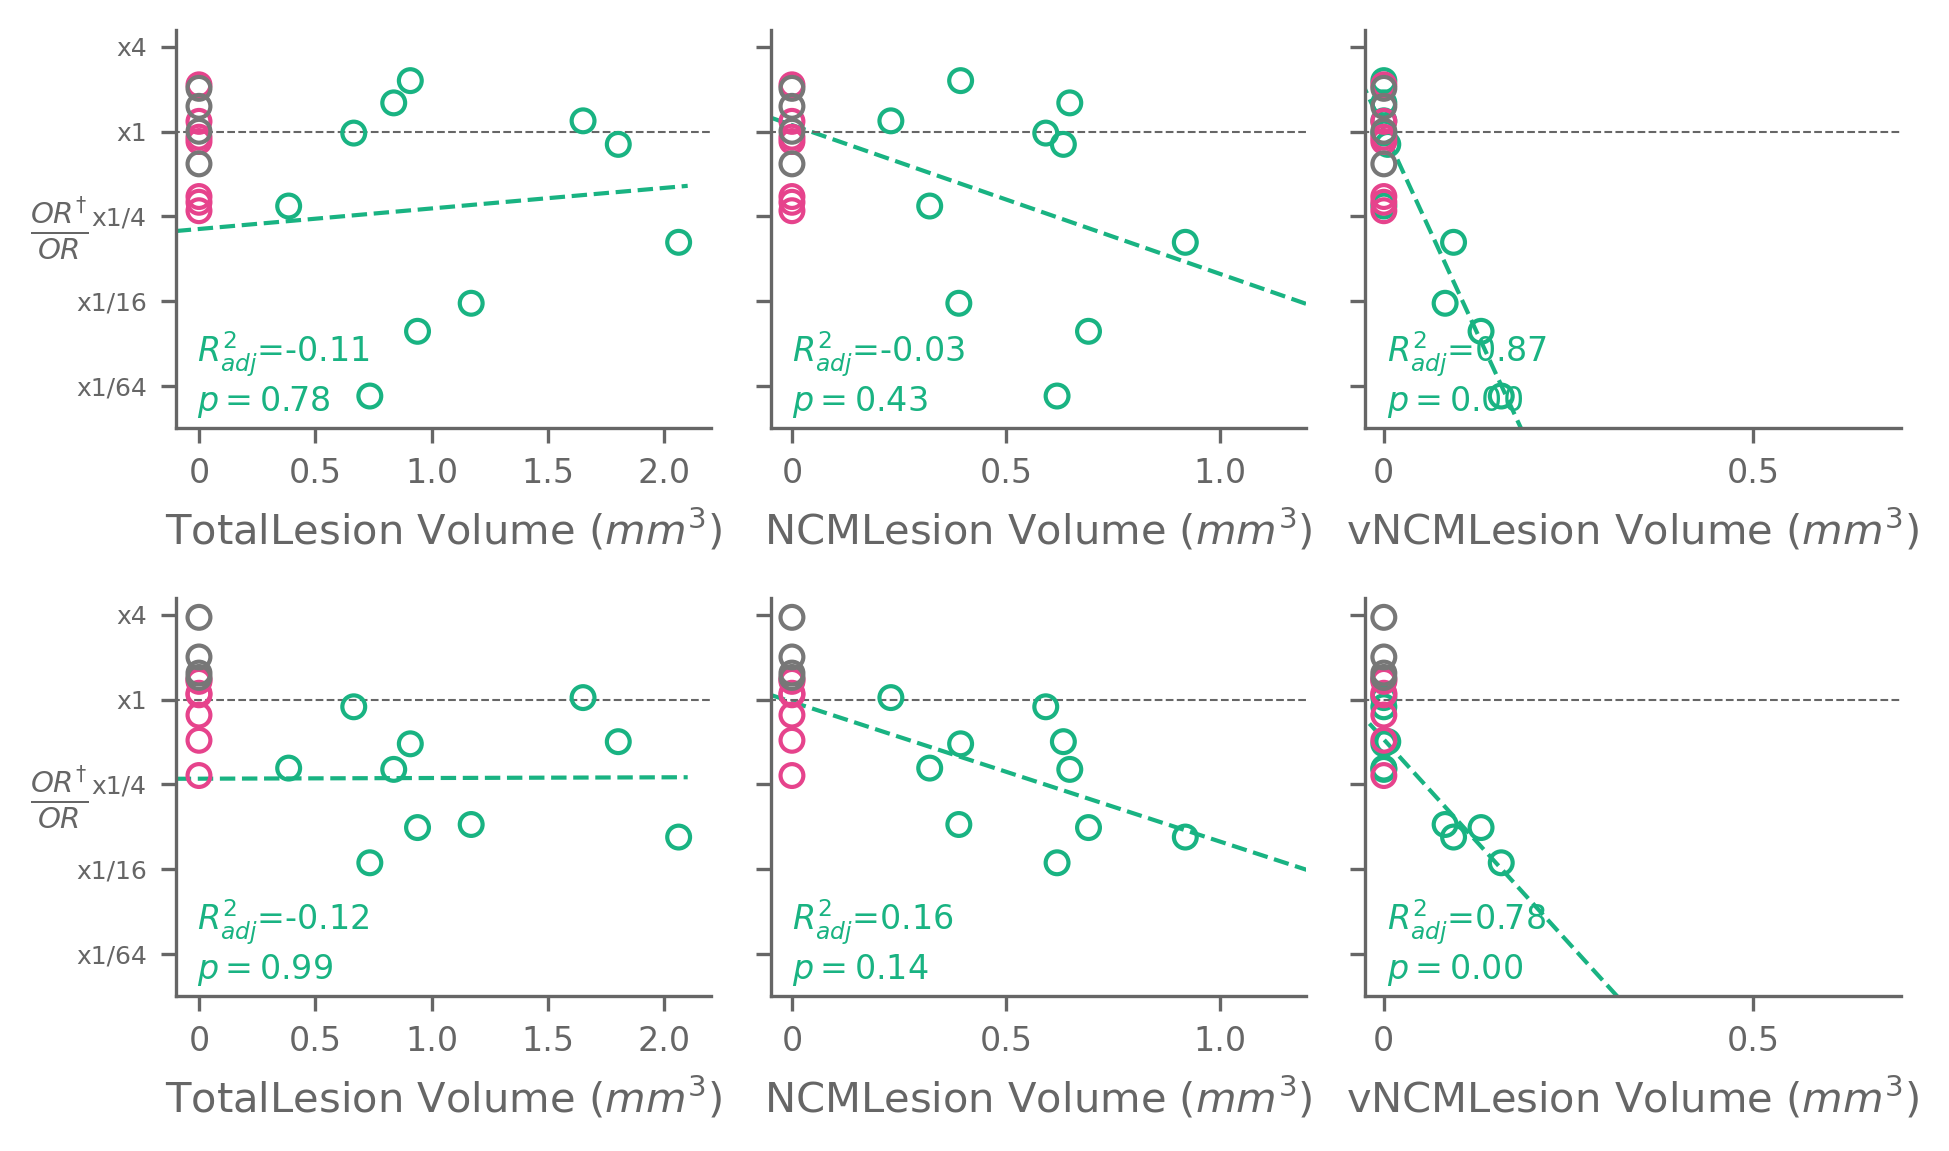

In [82]:
fig = figure_cm(COL2 - 1, 10, dpi=300)

print()
axes = fig.subplots(2, 3, sharey=True)#  gridspec_kw={"hspace": 1.0})
figure_7_new(call_type = ['SO'], anatomy = 'Total', ax=axes[0][0])
figure_7_new(call_type = ['SO'], anatomy = 'NCM', ax=axes[0][1])
figure_7_new(call_type = ['SO'], anatomy = 'vNCM', ax=axes[0][2])
figure_7_new(call_type = ['DC'], anatomy = 'Total', ax=axes[1][0])
figure_7_new(call_type = ['DC'], anatomy = 'NCM', ax=axes[1][1])
figure_7_new(call_type = ['DC'], anatomy = 'vNCM', ax=axes[1][2])


axes[0][0].set_ylabel(r"$\frac{OR^{\dagger}}{OR}$", fontsize=10, verticalalignment="center", rotation=0)
axes[1][0].set_ylabel(r"$\frac{OR^{\dagger}}{OR}$", fontsize=10, verticalalignment="center", rotation=0)

for ax in axes.flatten():
    border(ax, 1, 0, 0, 1)
    draw_logor_axes_markers(smallest=-7, biggest=2, convert_log=False, ax=ax)
    ax.set_ylim(-7, 2.4)
    
    #ax.set_xlim(-0.1, 2.2)
    #ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0], [0, 0.5, 1.0, 1.5, 2.0], fontsize=8)

# Different x axis
axes[0][0].set_xlim(-0.1, 2.2)
axes[0][0].set_xticks([0, 0.5, 1.0, 1.5, 2.0], [0, 0.5, 1.0, 1.5, 2.0], fontsize=8)
axes[0][1].set_xlim(-0.05, 1.2)
axes[0][1].set_xticks([0, 0.5, 1.0], [0, 0.5, 1.0], fontsize=8)
axes[0][2].set_xlim(-0.025, 0.7)
axes[0][2].set_xticks([0, 0.5], [0, 0.5], fontsize=8)
axes[1][0].set_xlim(-0.1, 2.2)
axes[1][0].set_xticks([0, 0.5, 1.0, 1.5, 2.0], [0, 0.5, 1.0, 1.5, 2.0], fontsize=8)
axes[1][1].set_xlim(-0.05, 1.2)
axes[1][1].set_xticks([0, 0.5, 1.0], [0, 0.5, 1.0], fontsize=8)
axes[1][2].set_xlim(-0.025, 0.7)
axes[1][2].set_xticks([0, 0.5], [0, 0.5], fontsize=8)


fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(savedir("fig7_new.svg"), format="svg", bbox_inches="tight")